# LGBM

### imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### load

In [38]:
df = pd.read_csv('consumption_temp.csv')
df.head(5)

,time,location,consumption,temperature
0,2022-04-07 21:00:00,bergen,1.113325,-0.3
1,2022-04-07 21:00:00,oslo,4.092830,1.0
2,2022-04-07 21:00:00,stavanger,2.057858,1.3
3,2022-04-07 21:00:00,tromsø,1.246582,-3.9
4,2022-04-07 21:00:00,trondheim,1.970098,-2.8


## Prepare the data

### preproc

In [39]:
def preprocess_data(df, city, starting_date):
    df = df.copy()
    df["datetime"] = pd.to_datetime(df["time"])

    # Filter city case-insensitively (and strip spaces)
    city_norm = city.strip().lower()
    df_city = df[df["location"].astype(str).str.strip().str.lower() == city_norm].copy()

    df_city = df_city.set_index("datetime").sort_index()
    df_city = df_city.loc[pd.Timestamp(starting_date):]

    return df_city


In [40]:
#preproc
# should convert timestamps, filter city and limit horizon
# No data cleaning actually needed, but include as theoretical step to handle future data issues
location_df = preprocess_data(df, city='bergen', starting_date='2022-08-01') 
location_df.head(5)

,time,location,consumption,temperature
datetime,,,,
2022-08-01 00:00:00,2022-08-01 00:00:00,bergen,0.730897,9.0
2022-08-01 01:00:00,2022-08-01 01:00:00,bergen,0.716152,9.5
2022-08-01 02:00:00,2022-08-01 02:00:00,bergen,0.721158,9.6
2022-08-01 03:00:00,2022-08-01 03:00:00,bergen,0.734186,9.5
2022-08-01 04:00:00,2022-08-01 04:00:00,bergen,0.785847,9.9


### feature engineering

In [41]:
import numpy as np
import pandas as pd

def add_time_features(
    df: pd.DataFrame,
    *,
    target_col: str = "consumption",
    drop_cols: list[str] | None = None,
    add_cyclical: bool = True,
    add_lags: bool = True,
    add_rollings: bool = True,
    lags: tuple[int, ...] = (24, 168),
    rolling_windows: tuple[int, ...] = (24, 168),
) -> pd.DataFrame:
    """
    Feature engineering for hourly day-ahead forecasting.

    Adds:
      - calendar features (hour, day_of_week, month, is_weekend)
      - cyclical encodings for hour/dow/month (sin/cos)
      - lag features on target (e.g., lag_24, lag_168)
      - rolling stats on target (mean/std), computed safely (past-only)

    Returns a NEW dataframe (does not modify input).
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("DataFrame index must be a DatetimeIndex. Did you set datetime as index in preprocess?")

    out = df.copy()

    # ---- Basic calendar features ----
    out["hour"] = out.index.hour
    out["day_of_week"] = out.index.dayofweek  # Mon=0
    out["month"] = out.index.month
    out["is_weekend"] = (out["day_of_week"] >= 5).astype(int)

    # ---- Cyclical encodings (recommended for hour/dow/month) ----
    if add_cyclical:
        out["hour_sin"] = np.sin(2 * np.pi * out["hour"] / 24.0)
        out["hour_cos"] = np.cos(2 * np.pi * out["hour"] / 24.0)

        out["dow_sin"] = np.sin(2 * np.pi * out["day_of_week"] / 7.0)
        out["dow_cos"] = np.cos(2 * np.pi * out["day_of_week"] / 7.0)

        out["month_sin"] = np.sin(2 * np.pi * (out["month"] - 1) / 12.0)
        out["month_cos"] = np.cos(2 * np.pi * (out["month"] - 1) / 12.0)

    # ---- Lags on target (most important predictors) ----
    if add_lags:
        if target_col not in out.columns:
            raise KeyError(f"target_col='{target_col}' not found in df columns.")
        for k in lags:
            out[f"lag_{k}"] = out[target_col].shift(k)

    # ---- Rolling stats on target (past-only; avoid leakage) ----
    if add_rollings:
        if target_col not in out.columns:
            raise KeyError(f"target_col='{target_col}' not found in df columns.")
        # shift(1) ensures rolling window does not include current timestamp
        shifted = out[target_col].shift(1)
        for w in rolling_windows:
            out[f"roll_mean_{w}"] = shifted.rolling(window=w, min_periods=w).mean()
            out[f"roll_std_{w}"]  = shifted.rolling(window=w, min_periods=w).std()

    # ---- Optional drops (safe: only drop if present) ----
    if drop_cols:
        out = out.drop(columns=[c for c in drop_cols if c in out.columns])

    return out


In [42]:
# ---- Feature engineering cell ----
data = location_df.copy()

data = add_time_features(
    data,
    target_col="consumption",
    drop_cols=["time", "location", "datetime"],
    add_cyclical=True,
    add_lags=True,
    add_rollings=True,
    lags=(24, 168),
    rolling_windows=(24, 168),
)

# NOTE: lags/rolling introduce NaNs at the beginning (need history).
# You can drop them once BEFORE building splits/training:
data = data.dropna()

data.head(12)

,consumption,temperature,hour,day_of_week,month,is_weekend,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,lag_24,lag_168,roll_mean_24,roll_std_24,roll_mean_168,roll_std_168
datetime,,,,,,,,,,,,,,,,,,
2022-08-08 00:00:00,0.849595,11.400000,0,0,8,0,0.000000,1.000000e+00,0.0,1.0,-0.5,-0.866025,0.834616,0.730897,1.059678,0.188253,0.929241,0.153736
2022-08-08 01:00:00,0.835019,11.600000,1,0,8,0,0.258819,9.659258e-01,0.0,1.0,-0.5,-0.866025,0.806819,0.716152,1.060302,0.187497,0.929947,0.153091
2022-08-08 02:00:00,0.815133,11.700000,2,0,8,0,0.500000,8.660254e-01,0.0,1.0,-0.5,-0.866025,0.791920,0.721158,1.061477,0.185921,0.930655,0.152370
2022-08-08 03:00:00,0.830007,11.700000,3,0,8,0,0.707107,7.071068e-01,0.0,1.0,-0.5,-0.866025,0.787244,0.734186,1.062445,0.184513,0.931214,0.151767
2022-08-08 04:00:00,0.858274,11.900000,4,0,8,0,0.866025,5.000000e-01,0.0,1.0,-0.5,-0.866025,0.740315,0.785847,1.064226,0.181928,0.931784,0.151201
2022-08-08 05:00:00,0.956703,12.300000,5,0,8,0,0.965926,2.588190e-01,0.0,1.0,-0.5,-0.866025,0.789503,0.811849,1.069141,0.174228,0.932216,0.150886
2022-08-08 06:00:00,0.963471,12.800000,6,0,8,0,1.000000,6.123234e-17,0.0,1.0,-0.5,-0.866025,0.888225,0.847581,1.076108,0.165694,0.933078,0.150607
2022-08-08 07:00:00,0.939715,13.500000,7,0,8,0,0.965926,-2.588190e-01,0.0,1.0,-0.5,-0.866025,1.018325,0.867539,1.079243,0.162668,0.933768,0.150479
2022-08-08 08:00:00,0.924570,14.300000,8,0,8,0,0.866025,-5.000000e-01,0.0,1.0,-0.5,-0.866025,1.157139,0.845731,1.075968,0.164727,0.934197,0.150391


### split the data

In [43]:
import pandas as pd
from dataclasses import dataclass
from typing import Iterator, Optional

@dataclass
class SlidingSplit:
    forecast_date: pd.Timestamp
    # boundaries (useful for logging/debug)
    train_start: pd.Timestamp
    train_end: pd.Timestamp
    val_start: pd.Timestamp
    val_end: pd.Timestamp
    test_start: pd.Timestamp
    test_end: pd.Timestamp
    # data
    X_train: pd.DataFrame
    y_train: pd.Series
    X_val: pd.DataFrame
    y_val: pd.Series
    X_test: pd.DataFrame
    y_test: pd.Series


def iter_sliding_day_ahead_splits(
    df: pd.DataFrame,
    target_col: str,
    feature_cols: list[str],
    *,
    last_incomplete_day: str = "2023-04-02",
    last_complete_day: str = "2023-04-01",
    test_days: int = 14,
    history_days: int = 180,       # train+val horizon (sliding)
    val_days: int = 14,            # inside the 180d window
) -> Iterator[SlidingSplit]:
    """
    Sliding time-window splits for day-ahead forecasting.

    - Drops all data on/after `last_incomplete_day` (assumed incomplete).
    - Uses the last complete day as `last_complete_day`.
    - Test window = last `test_days` days ending `last_complete_day` (inclusive).
    - For each test day D:
        * history window = [D - history_days, D)
        * validation = last `val_days` of history
        * training = the rest of history before validation
        * test = [D, D+1) (one day ahead, 24h if hourly)
    """

    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("df.index must be a DatetimeIndex")

    df = df.sort_index()

    tz = df.index.tz
    def _ts(s: str) -> pd.Timestamp:
        t = pd.Timestamp(s)
        if tz is not None:
            t = t.tz_localize(tz) if t.tzinfo is None else t.tz_convert(tz)
        return t.normalize()

    last_incomplete = _ts(last_incomplete_day)
    last_complete = _ts(last_complete_day)

    # 1) Exclude incomplete last day (drop everything from 2023-04-02 00:00 and onward)
    df = df.loc[: last_incomplete - pd.Timedelta(seconds=1)]

    # 2) Ensure we don’t accidentally include anything beyond last_complete day
    df = df.loc[: last_complete + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)]

    # 3) Define test window days (inclusive)
    test_start_day = last_complete - pd.Timedelta(days=test_days - 1)
    test_days_range = pd.date_range(test_start_day, last_complete, freq="D", tz=tz)

    for D in test_days_range:
        test_start = D
        test_end = D + pd.Timedelta(days=1)

        # history window immediately before D
        hist_end = test_start
        hist_start = hist_end - pd.Timedelta(days=history_days)

        # clip to available data
        hist_start = max(hist_start, df.index.min().normalize())

        # validation = last val_days inside history
        val_end = hist_end
        val_start = val_end - pd.Timedelta(days=val_days)
        val_start = max(val_start, hist_start)

        train_start = hist_start
        train_end = val_start  # exclusive

        # Slice hourly data (assumes hourly grid; if DST causes 23/25h days, this still works)
        train_slice = df.loc[train_start: train_end - pd.Timedelta(hours=1)]
        val_slice   = df.loc[val_start:   val_end   - pd.Timedelta(hours=1)]
        test_slice  = df.loc[test_start:  test_end  - pd.Timedelta(hours=1)]

        # Safety: skip if missing coverage
        if train_slice.empty or val_slice.empty or test_slice.empty:
            continue

        yield SlidingSplit(
            forecast_date=D,
            train_start=train_start, train_end=train_end,
            val_start=val_start, val_end=val_end,
            test_start=test_start, test_end=test_end,
            X_train=train_slice[feature_cols],
            y_train=train_slice[target_col],
            X_val=val_slice[feature_cols],
            y_val=val_slice[target_col],
            X_test=test_slice[feature_cols],
            y_test=test_slice[target_col],
        )


# ----------------
# Example usage
# ----------------
target_col = "consumption"
feature_cols = [c for c in data.columns if c != target_col]

splits = list(iter_sliding_day_ahead_splits(
    data,
    target_col=target_col,
    feature_cols=feature_cols,
    last_incomplete_day="2023-04-02",
    last_complete_day="2023-04-01",
    test_days=14,
    history_days=180,
    val_days=14,
))

print("Num test days:", len(splits))
print("Test window:", splits[0].forecast_date.date(), "->", splits[-1].forecast_date.date())
print("First split train/val/test:",
      splits[0].train_start.date(), "->", (splits[0].train_end - pd.Timedelta(days=0)).date(),
      "|", splits[0].val_start.date(), "->", (splits[0].val_end - pd.Timedelta(days=0)).date(),
      "| test day", splits[0].forecast_date.date())


Num test days: 14
Test window: 2023-03-19 -> 2023-04-01
First split train/val/test: 2022-09-20 -> 2023-03-05 | 2023-03-05 -> 2023-03-19 | test day 2023-03-19


## Train

### model architecture

In [44]:
# =========================
# Model architecture (LGBM)
# =========================

import lightgbm as lgb

def make_lgbm_model(params: dict | None = None) -> lgb.LGBMRegressor:
    base_params = dict(
        objective="regression",
        boosting_type="gbdt",
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=63,
        min_child_samples=50,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=0.0,
        random_state=42,
        n_jobs=-1,
        verbosity=-1,   # keep internal logs quiet
    )
    if params:
        base_params.update(params)
    return lgb.LGBMRegressor(**base_params)


# LGBM_SEARCH_SPACE = {
#     "learning_rate": [0.01, 0.03, 0.05],
#     "num_leaves": [24, 50, 63],
#     "min_child_samples": [10, 20, 50],
#     "subsample": [0.7, 0.8, 0.9],
#     "colsample_bytree": [0.7, 0.8, 0.9],
#     "reg_alpha": [0.0, 1e-2, 1e-1],
#     "reg_lambda": [0.0, 1e-2, 1e-1],
# }

model = make_lgbm_model()
model


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.03
,n_estimators,2000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,50


### Training loop

In [45]:
from __future__ import annotations

import random
import numpy as np
import pandas as pd
from datetime import datetime
import lightgbm as lgb

# -------------------
# Metrics + logging
# -------------------
def mae(y_true, y_pred) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def smape(y_true, y_pred, eps: float = 1e-9) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum((np.abs(y_true) + np.abs(y_pred)) / 2.0, eps)
    return float(np.mean(np.abs(y_true - y_pred) / denom)) * 100.0

def log(msg: str) -> None:
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

In [46]:
# -------------------
# Build splits helper
# -------------------
def build_sliding_splits(
    df: pd.DataFrame,
    target_col: str,
    feature_cols: list[str],
    *,
    last_incomplete_day="2023-04-02",
    last_complete_day="2023-04-01",
    test_days=14,
    history_days=180,
    val_days=14,
) -> list:
    return list(iter_sliding_day_ahead_splits(
        df,
        target_col=target_col,
        feature_cols=feature_cols,
        last_incomplete_day=last_incomplete_day,
        last_complete_day=last_complete_day,
        test_days=test_days,
        history_days=history_days,
        val_days=val_days,
    ))

In [47]:
# =====================
# Configure split periods (validation right before test)
# =====================
target_col = "consumption"
feature_cols = [c for c in data.columns if c != target_col]

# Build TEST splits (fixed by spec)
test_splits = build_sliding_splits(
    data,
    target_col=target_col,
    feature_cols=feature_cols,
    last_incomplete_day="2023-04-02",
    last_complete_day="2023-04-01",
    test_days=14,
    history_days=180,
    val_days=14,
)

test_start_day = test_splits[0].forecast_date.normalize()      # 2023-03-19
test_end_day   = test_splits[-1].forecast_date.normalize()     # 2023-04-01

log(f"Prepared TEST splits: {len(test_splits)} days "
    f"({test_start_day.date()} -> {test_end_day.date()})")

# Choose tuning days as the 14 days immediately before test starts
tune_last_complete_day = (test_start_day - pd.Timedelta(days=1)).normalize()      # 2023-03-18
tune_last_incomplete_day = (tune_last_complete_day + pd.Timedelta(days=1)).normalize()  # 2023-03-19 (excluded)
# (we use "incomplete_day" here just as a cutoff boundary to exclude that day and later)

tune_splits = build_sliding_splits(
    data,
    target_col=target_col,
    feature_cols=feature_cols,
    last_incomplete_day=str(tune_last_incomplete_day.date()),  # "2023-03-19"
    last_complete_day=str(tune_last_complete_day.date()),      # "2023-03-18"
    test_days=14,          # tuning horizon length (14 days)
    history_days=180,
    val_days=14,
)

tune_start_day = tune_splits[0].forecast_date.normalize()
tune_end_day   = tune_splits[-1].forecast_date.normalize()

log(f"Prepared TUNE splits: {len(tune_splits)} days "
    f"({tune_start_day.date()} -> {tune_end_day.date()})")


[12:54:00] Prepared TEST splits: 14 days (2023-03-19 -> 2023-04-01)
[12:54:00] Prepared TUNE splits: 14 days (2023-03-05 -> 2023-03-18)


In [48]:
# -------------------------------------------------------
# 1) TUNING: train on train-slice, validate on val-slice
#    (use ONE representative tuning horizon, not test)
# -------------------------------------------------------
def score_params_on_val_splits(
    val_splits: list,
    params: dict,
    metric_fn=mae,
    *,
    use_early_stopping: bool = True,
    log_every: int = 5,
) -> float:
    scores = []
    for i, split in enumerate(val_splits, start=1):
        model = make_lgbm_model(params)

        if use_early_stopping:
            model.fit(
                split.X_train, split.y_train,
                eval_set=[(split.X_val, split.y_val)],
                eval_metric="l1",
                callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
            )
        else:
            model.fit(split.X_train, split.y_train)

        y_val_pred = model.predict(split.X_val)
        s = metric_fn(split.y_val.values, y_val_pred)
        scores.append(s)

        if log_every and (i % log_every == 0 or i == 1 or i == len(val_splits)):
            log(f"  VAL eval {i:>2}/{len(val_splits)}  day={split.forecast_date.date()}  "
                f"{metric_fn.__name__}={s:.4f}")

    return float(np.mean(scores))


import itertools
import pandas as pd

def _grid_product(space: dict) -> list[dict]:
    keys = list(space.keys())
    combos = []
    for values in itertools.product(*[space[k] for k in keys]):
        combos.append(dict(zip(keys, values)))
    return combos


def grid_then_refine_search(
    val_splits: list,
    *,
    metric_fn=mae,
    use_early_stopping: bool = True,
    top_k: int = 3,
    log_every: int = 10,
    refine_cap: int = 60,   # hard cap per candidate
) -> tuple[dict, pd.DataFrame]:

    # -------------------------
    # Stage A: Coarse grid
    # -------------------------
    coarse_space = {
        "learning_rate": [0.03, 0.05],
        "num_leaves": [31, 63, 127],
        "min_child_samples": [20, 50, 100],
        "reg_lambda": [0.0, 1e-2, 1e-1],
        "subsample": [0.8],
        "colsample_bytree": [0.8],
        "reg_alpha": [0.0],
    }

    coarse_params_list = _grid_product(coarse_space)
    log(f"Stage A (coarse grid): {len(coarse_params_list)} configs")

    coarse_rows = []
    for i, params in enumerate(coarse_params_list, start=1):
        if i % log_every == 0 or i == 1 or i == len(coarse_params_list):
            log(f"  Coarse {i}/{len(coarse_params_list)} params={params}")

        score = score_params_on_val_splits(
            val_splits,
            params,
            metric_fn=metric_fn,
            use_early_stopping=use_early_stopping,
            log_every=max(1, len(val_splits)//3),
        )
        coarse_rows.append({"stage": "coarse", "score": score, **params})

    coarse_df = pd.DataFrame(coarse_rows).sort_values("score").reset_index(drop=True)
    log(f"Best coarse score: {coarse_df.loc[0,'score']:.4f}")

    top_candidates = coarse_df.head(top_k).to_dict(orient="records")

    # -------------------------
    # Stage B: Refine locally (SMALL)
    # -------------------------
    refine_rows = []
    log(f"Stage B (refine): refining around top {top_k} coarse configs (cap={refine_cap} each)")

    for c_idx, base in enumerate(top_candidates, start=1):
        base_params = {k: base[k] for k in coarse_space.keys()}

        lr = float(base_params["learning_rate"])
        leaves = int(base_params["num_leaves"])
        mcs = int(base_params["min_child_samples"])
        rl = float(base_params["reg_lambda"])

        # helper to make 2-point neighborhood
        def two_point_neighborhood(value, lower, upper, step=None, mult=None):
            if mult is not None:
                alt = value * mult
            elif step is not None:
                alt = value + step
            else:
                alt = value
            alt = max(lower, min(upper, alt))
            return sorted(set([value, alt]))

        refine_space = {
            # 2 values each => 2^4 = 16 core combos
            "learning_rate": two_point_neighborhood(lr, 0.005, 0.2, mult=0.8),         # lr and lr*0.8
            "num_leaves": two_point_neighborhood(leaves, 15, 255, step=+16),          # leaves and leaves+16
            "min_child_samples": two_point_neighborhood(mcs, 5, 300, step=+20),       # mcs and mcs+20
            "reg_lambda": two_point_neighborhood(rl, 0.0, 10.0, mult=10.0 if rl > 0 else None),
            # keep these FIXED during refine (huge combinatoric reducers)
            "subsample": [base_params["subsample"]],
            "colsample_bytree": [base_params["colsample_bytree"]],
            "reg_alpha": [base_params["reg_alpha"]],
        }

        refine_list = _grid_product(refine_space)

        # hard cap (in case some neighborhoods become 3 values)
        if len(refine_list) > refine_cap:
            refine_list = refine_list[:refine_cap]

        log(f"  Candidate {c_idx}/{top_k}: refining {len(refine_list)} configs around {base_params}")

        for j, params in enumerate(refine_list, start=1):
            if j == 1 or j == len(refine_list) or (log_every and j % log_every == 0):
                log(f"    Refine {j}/{len(refine_list)} params={params}")

            score = score_params_on_val_splits(
                val_splits,
                params,
                metric_fn=metric_fn,
                use_early_stopping=use_early_stopping,
                log_every=0,
            )
            refine_rows.append({"stage": "refine", "score": score, **params})

    refine_df = pd.DataFrame(refine_rows).sort_values("score").reset_index(drop=True)

    results_df = pd.concat([coarse_df, refine_df], ignore_index=True).sort_values("score").reset_index(drop=True)

    best_params = results_df.iloc[0].to_dict()
    best_params.pop("stage", None)
    best_params.pop("score", None)

    log(f"Best overall score: {results_df.loc[0,'score']:.4f}")
    log(f"Best params: {best_params}")

    return best_params, results_df


In [49]:
# -------------------------------------------------------
# 2) TESTING: retrain on ALL available (train+val),
#    predict ONE test day, then move forward, repeat.
# -------------------------------------------------------
def walk_forward_test(
    test_splits: list,
    params: dict,
    *,
    use_early_stopping: bool = False,  # usually OFF here because we fit on train+val (no val left)
) -> tuple[pd.DataFrame, pd.DataFrame]:
    pred_rows = []
    daily_rows = []

    log(f"Running TEST backtest: {len(test_splits)} days (retrain daily on train+val)")

    for i, split in enumerate(test_splits, start=1):
        # retrain on ALL available history before this test day
        X_fit = pd.concat([split.X_train, split.X_val], axis=0)
        y_fit = pd.concat([split.y_train, split.y_val], axis=0)

        model = make_lgbm_model(params)

        # No eval_set available if you fit on train+val, unless you carve out an inner val.
        model.fit(X_fit, y_fit)

        y_true = split.y_test.values
        y_pred = model.predict(split.X_test)

        row = {
            "forecast_date": split.forecast_date,
            "MAE": mae(y_true, y_pred),
            "RMSE": rmse(y_true, y_pred),
            "SMAPE_%": smape(y_true, y_pred),
        }
        daily_rows.append(row)

        log(f"TEST {i:>2}/{len(test_splits)}  day={split.forecast_date.date()}  "
            f"MAE={row['MAE']:.4f} RMSE={row['RMSE']:.4f} SMAPE={row['SMAPE_%']:.2f}%  "
            f"n_fit={len(X_fit):,}")

        pred_rows.append(pd.DataFrame({
            "forecast_date": split.forecast_date,
            "timestamp": split.X_test.index,
            "y_true": y_true,
            "y_pred": y_pred,
        }))

    daily_metrics = pd.DataFrame(daily_rows).sort_values("forecast_date").reset_index(drop=True)
    predictions = pd.concat(pred_rows, ignore_index=True)
    return daily_metrics, predictions

In [50]:
# already ran tuning, so just run test now with best_params

# =====================
# 1) Tune on validation
# =====================
best_params, tune_results = grid_then_refine_search(
    tune_splits,
    metric_fn=mae,
    use_early_stopping=True,
    top_k=3,      # speed knob
    log_every=10,
)

log(f"Best params: {best_params}")
display(tune_results.head(10))

[12:54:25] Stage A (coarse grid): 54 configs
[12:54:25]   Coarse 1/54 params={'learning_rate': 0.03, 'num_leaves': 31, 'min_child_samples': 20, 'reg_lambda': 0.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.0}
[12:54:26]   VAL eval  1/14  day=2023-03-05  mae=0.1130
[12:54:27]   VAL eval  4/14  day=2023-03-08  mae=0.1189
[12:54:28]   VAL eval  8/14  day=2023-03-12  mae=0.1237
[12:54:29]   VAL eval 12/14  day=2023-03-16  mae=0.1300
[12:54:31]   VAL eval 14/14  day=2023-03-18  mae=0.1393
[12:54:31]   VAL eval  1/14  day=2023-03-05  mae=0.1157
[12:54:32]   VAL eval  4/14  day=2023-03-08  mae=0.1214
[12:54:34]   VAL eval  8/14  day=2023-03-12  mae=0.1201
[12:54:36]   VAL eval 12/14  day=2023-03-16  mae=0.1298
[12:54:37]   VAL eval 14/14  day=2023-03-18  mae=0.1400
[12:54:38]   VAL eval  1/14  day=2023-03-05  mae=0.1148
[12:54:38]   VAL eval  4/14  day=2023-03-08  mae=0.1191
[12:54:39]   VAL eval  8/14  day=2023-03-12  mae=0.1254
[12:54:41]   VAL eval 12/14  day=2023-03-16  mae

,stage,score,learning_rate,num_leaves,min_child_samples,reg_lambda,subsample,colsample_bytree,reg_alpha
0,refine,0.122466,0.05,47,120,0.10,0.8,0.8,0.0
1,refine,0.122466,0.05,31,120,0.10,0.8,0.8,0.0
2,refine,0.122466,0.05,127,120,0.10,0.8,0.8,0.0
3,refine,0.122466,0.05,143,120,0.10,0.8,0.8,0.0
4,coarse,0.122683,0.05,31,100,0.01,0.8,0.8,0.0
5,refine,0.122683,0.05,31,100,0.01,0.8,0.8,0.0
6,refine,0.122761,0.05,31,100,0.00,0.8,0.8,0.0
7,coarse,0.122761,0.05,31,100,0.00,0.8,0.8,0.0
8,refine,0.122994,0.05,143,100,0.01,0.8,0.8,0.0
9,refine,0.122994,0.05,47,100,0.01,0.8,0.8,0.0


In [51]:
# =====================
# 2) Retrain+test day-ahead
# =====================
daily_metrics, predictions = walk_forward_test(
    test_splits,
    best_params,
)

log(f"Overall MAE:   {daily_metrics['MAE'].mean():.4f}")
log(f"Overall RMSE:  {daily_metrics['RMSE'].mean():.4f}")
log(f"Overall SMAPE: {daily_metrics['SMAPE_%'].mean():.2f}%")

display(daily_metrics)
predictions.head()


[13:04:19] Running TEST backtest: 14 days (retrain daily on train+val)
[13:04:21] TEST  1/14  day=2023-03-19  MAE=0.1632 RMSE=0.2017 SMAPE=5.52%  n_fit=4,320
[13:04:23] TEST  2/14  day=2023-03-20  MAE=0.1138 RMSE=0.1437 SMAPE=4.10%  n_fit=4,320
[13:04:25] TEST  3/14  day=2023-03-21  MAE=0.1248 RMSE=0.1384 SMAPE=4.48%  n_fit=4,320
[13:04:26] TEST  4/14  day=2023-03-22  MAE=0.0732 RMSE=0.0873 SMAPE=2.70%  n_fit=4,320
[13:04:28] TEST  5/14  day=2023-03-23  MAE=0.0548 RMSE=0.0614 SMAPE=2.02%  n_fit=4,320
[13:04:30] TEST  6/14  day=2023-03-24  MAE=0.0624 RMSE=0.0728 SMAPE=2.30%  n_fit=4,320
[13:04:32] TEST  7/14  day=2023-03-25  MAE=0.1285 RMSE=0.1538 SMAPE=4.65%  n_fit=4,320
[13:04:34] TEST  8/14  day=2023-03-26  MAE=0.1084 RMSE=0.1247 SMAPE=3.76%  n_fit=4,320
[13:04:35] TEST  9/14  day=2023-03-27  MAE=0.0980 RMSE=0.1211 SMAPE=3.43%  n_fit=4,320
[13:04:37] TEST 10/14  day=2023-03-28  MAE=0.2030 RMSE=0.2591 SMAPE=6.48%  n_fit=4,320
[13:04:39] TEST 11/14  day=2023-03-29  MAE=0.1973 RMSE=0.22

,forecast_date,MAE,RMSE,SMAPE_%
0,2023-03-19,0.163194,0.201745,5.523645
1,2023-03-20,0.113825,0.143700,4.104675
2,2023-03-21,0.124848,0.138371,4.477563
3,2023-03-22,0.073176,0.087266,2.696325
4,2023-03-23,0.054825,0.061371,2.018891
5,2023-03-24,0.062390,0.072823,2.300334
6,2023-03-25,0.128455,0.153849,4.645757
7,2023-03-26,0.108402,0.124688,3.761432
8,2023-03-27,0.097967,0.121130,3.433580
9,2023-03-28,0.202991,0.259097,6.481273


,forecast_date,timestamp,y_true,y_pred
0,2023-03-19,2023-03-19 00:00:00,2.589399,2.539268
1,2023-03-19,2023-03-19 01:00:00,2.504455,2.459911
2,2023-03-19,2023-03-19 02:00:00,2.445723,2.430934
3,2023-03-19,2023-03-19 03:00:00,2.400561,2.459952
4,2023-03-19,2023-03-19 04:00:00,2.341152,2.439369


In [52]:
import pandas as pd
import numpy as np

def baseline_day_ahead_predict_sliding(
    df: pd.DataFrame,
    target_col: str,
    *,
    last_incomplete_day: str = "2023-04-02",
    last_complete_day: str = "2023-04-01",
    test_days: int = 14,
    history_days: int = 180,
    val_days: int = 14,
) -> pd.DataFrame:
    """
    Correct baseline: predict each hour as the value from exactly 24 hours earlier.
    i.e. y_pred[t] = y_true[t - 24h]
    Uses the same NEW sliding split/test window.
    """
    df = df.sort_index()

    # splitter needs feature_cols, but baseline doesn't use them
    feature_cols_dummy = [c for c in df.columns if c != target_col]

    splits = list(iter_sliding_day_ahead_splits(
        df,
        target_col=target_col,
        feature_cols=feature_cols_dummy,
        last_incomplete_day=last_incomplete_day,
        last_complete_day=last_complete_day,
        test_days=test_days,
        history_days=history_days,
        val_days=val_days,
    ))

    preds = []

    for split in splits:
        # Forecast timestamps for day D (hourly)
        ts = split.X_test.index

        # Yesterday timestamps (same clock hour, previous day)
        ts_prev = ts - pd.Timedelta(days=1)

        # Pull yesterday's values hour-by-hour
        y_pred = df[target_col].reindex(ts_prev).to_numpy()

        # Safety fallback if any missing
        # (e.g. missing hours) -> fill with last observed training value
        if np.isnan(y_pred).any():
            fallback = float(split.y_train.iloc[-1])
            y_pred = np.where(np.isnan(y_pred), fallback, y_pred)

        preds.append(pd.DataFrame({
            "forecast_date": split.forecast_date,
            "timestamp": ts,
            "y_true": split.y_test.values,
            "y_pred": y_pred,
        }))

    return pd.concat(preds, ignore_index=True)


In [53]:
# --- Test the baseline on the NEW test window (last 14 complete days ending 2023-04-01) ---

target_col = "consumption"  # adjust if your column name differs

baseline_predictions = baseline_day_ahead_predict_sliding(
    df=data,
    target_col=target_col,
    last_incomplete_day="2023-04-02",
    last_complete_day="2023-04-01",
    test_days=14,
    history_days=180,
    val_days=14,
)

log(f"Baseline test window: {baseline_predictions['forecast_date'].min().date()} "
    f"-> {baseline_predictions['forecast_date'].max().date()} "
    f"({baseline_predictions['forecast_date'].nunique()} days)")

# Metrics
baseline_mae = mae(baseline_predictions["y_true"].values, baseline_predictions["y_pred"].values)
log(f"Baseline MAE:   {baseline_mae:.4f}")

baseline_rmse = rmse(baseline_predictions["y_true"].values, baseline_predictions["y_pred"].values)
log(f"Baseline RMSE:  {baseline_rmse:.4f}")

baseline_smape = smape(baseline_predictions["y_true"].values, baseline_predictions["y_pred"].values)
log(f"Baseline SMAPE: {baseline_smape:.2f}%")


[13:05:00] Baseline test window: 2023-03-19 -> 2023-04-01 (14 days)
[13:05:00] Baseline MAE:   0.2137
[13:05:00] Baseline RMSE:  0.2749
[13:05:00] Baseline SMAPE: 7.49%


In [54]:
# pick one forecast day
d = baseline_predictions["forecast_date"].iloc[0]
day = baseline_predictions[baseline_predictions["forecast_date"] == d].copy()

# compare timestamps in prediction day vs "yesterday"
print(day["timestamp"].min(), "->", day["timestamp"].max())


2023-03-19 00:00:00 -> 2023-03-19 23:00:00


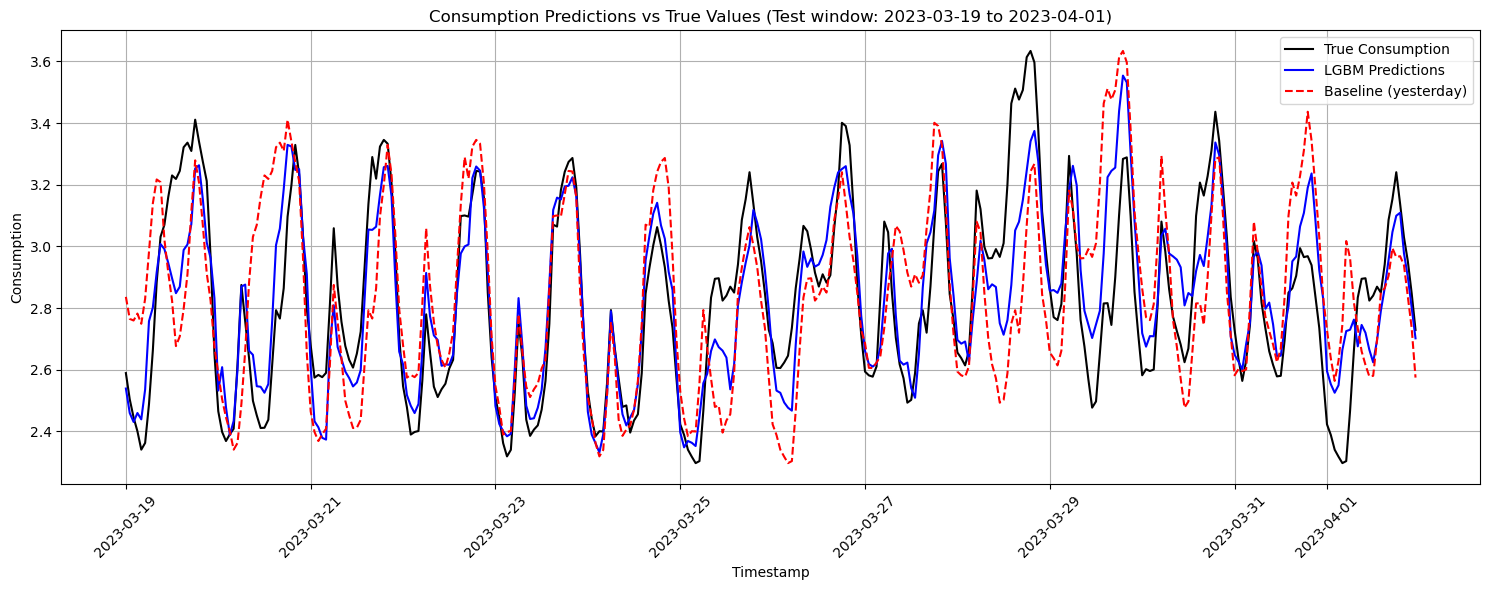

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

start_ts = pd.Timestamp("2023-03-19")
end_ts   = pd.Timestamp("2023-04-02")  # exclusive

test_period = predictions[(predictions["timestamp"] >= start_ts) & (predictions["timestamp"] < end_ts)]
baseline_period = baseline_predictions[(baseline_predictions["timestamp"] >= start_ts) & (baseline_predictions["timestamp"] < end_ts)]

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(test_period["timestamp"], test_period["y_true"], label="True Consumption", color="black")
ax.plot(test_period["timestamp"], test_period["y_pred"], label="LGBM Predictions", color="blue")
ax.plot(baseline_period["timestamp"], baseline_period["y_pred"], label="Baseline (yesterday)", color="red", linestyle="--")

ax.set_title("Consumption Predictions vs True Values (Test window: 2023-03-19 to 2023-04-01)")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Consumption")
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


,feature,importance_gain,importance_split
11,lag_24,23308.266554,6777
13,roll_mean_24,8096.525185,5820
12,lag_168,818.142936,6175
0,temperature,704.174090,5749
5,hour_sin,682.357549,1911
15,roll_mean_168,306.967815,5832
1,hour,206.729211,2168
2,day_of_week,145.237120,1515
6,hour_cos,100.684008,2018
14,roll_std_24,88.219477,6403


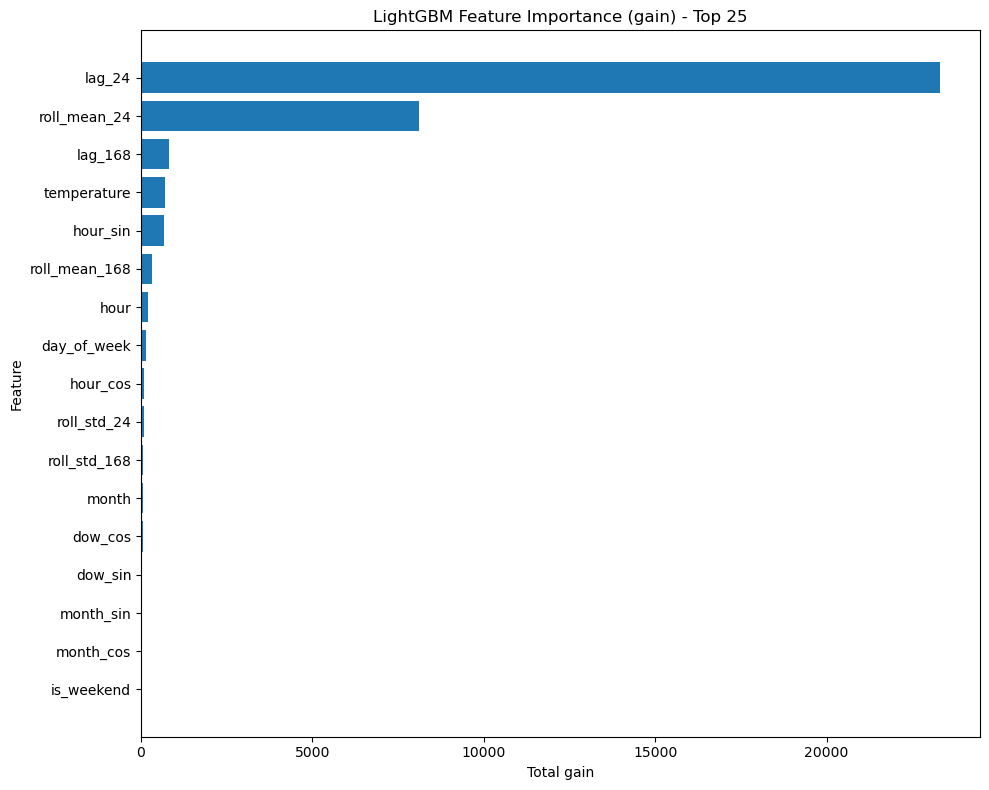

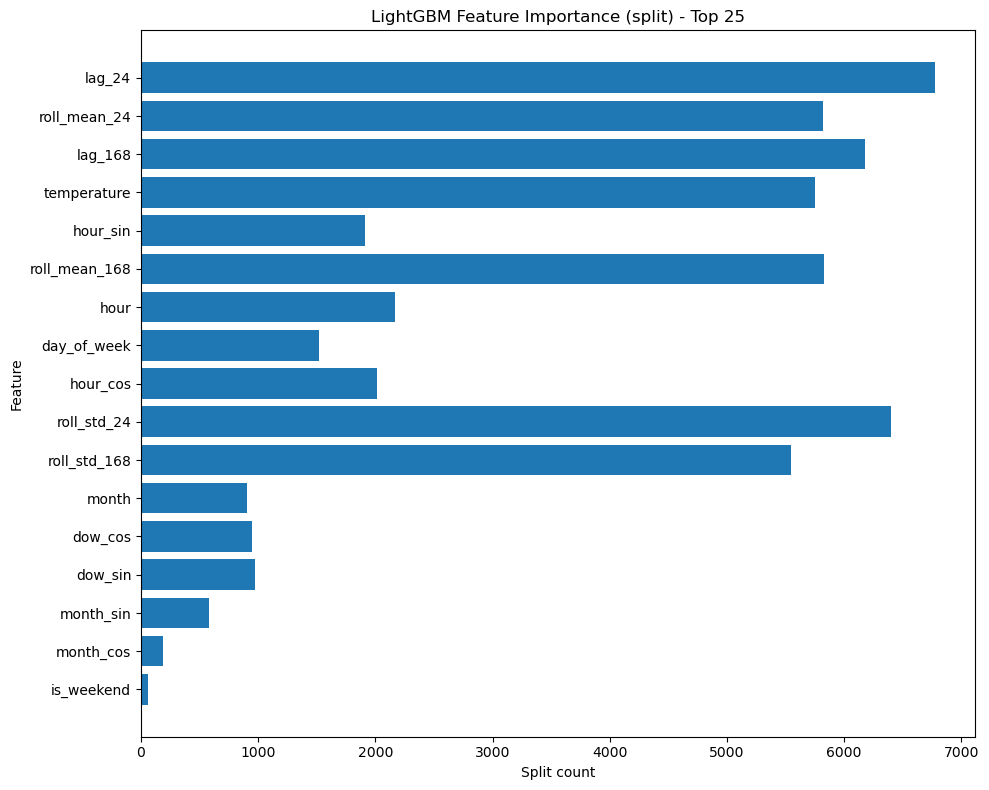

In [56]:
# ==========================================
# Feature importance (LightGBM) + diagnostics
# ==========================================
# This fits ONE final model on the latest available history before the first test day,
# then plots feature importances (gain + split). This is mainly for interpretation.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

# --- pick a reference day to fit an "analysis model" ---
# Use the FIRST test split (train+val history right before the test window starts)
ref_split = test_splits[0]

X_fit = pd.concat([ref_split.X_train, ref_split.X_val], axis=0)
y_fit = pd.concat([ref_split.y_train, ref_split.y_val], axis=0)

analysis_model = make_lgbm_model(best_params)
analysis_model.fit(X_fit, y_fit)

booster = analysis_model.booster_

# Importance as arrays
feat_names = booster.feature_name()
imp_gain = booster.feature_importance(importance_type="gain")
imp_split = booster.feature_importance(importance_type="split")

imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance_gain": imp_gain,
    "importance_split": imp_split,
}).sort_values("importance_gain", ascending=False)

display(imp_df.head(30))

# --- Plot top-N ---
TOP_N = 25
top = imp_df.head(TOP_N).iloc[::-1]  # reverse for nicer barh

plt.figure(figsize=(10, 8))
plt.barh(top["feature"], top["importance_gain"])
plt.title(f"LightGBM Feature Importance (gain) - Top {TOP_N}")
plt.xlabel("Total gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
plt.barh(top["feature"], top["importance_split"])
plt.title(f"LightGBM Feature Importance (split) - Top {TOP_N}")
plt.xlabel("Split count")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Test

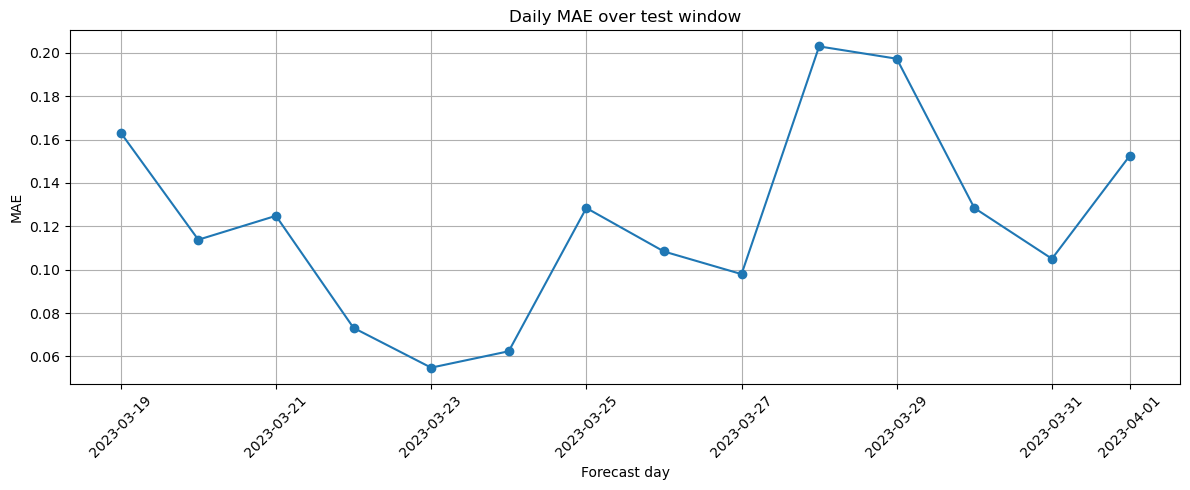

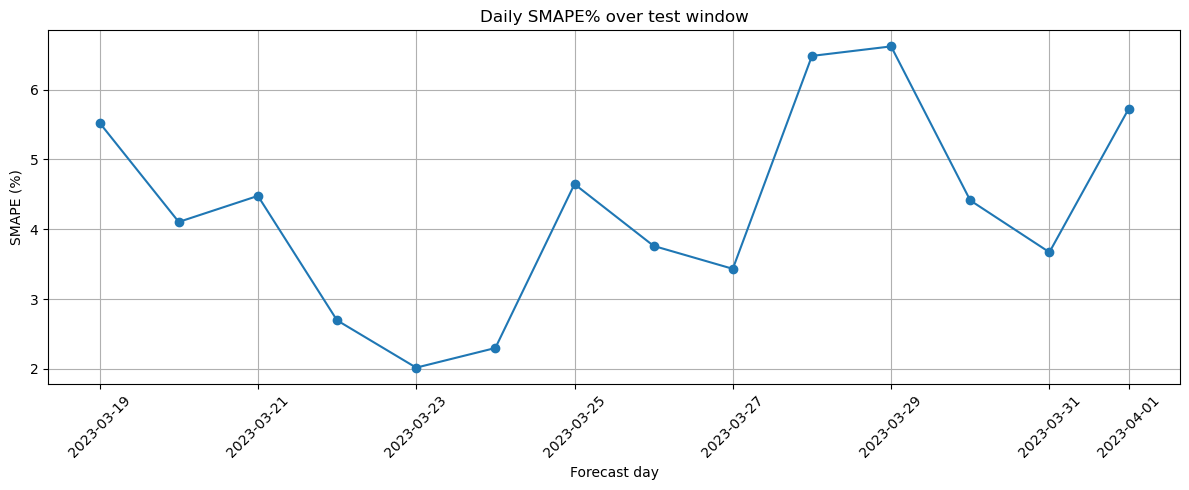

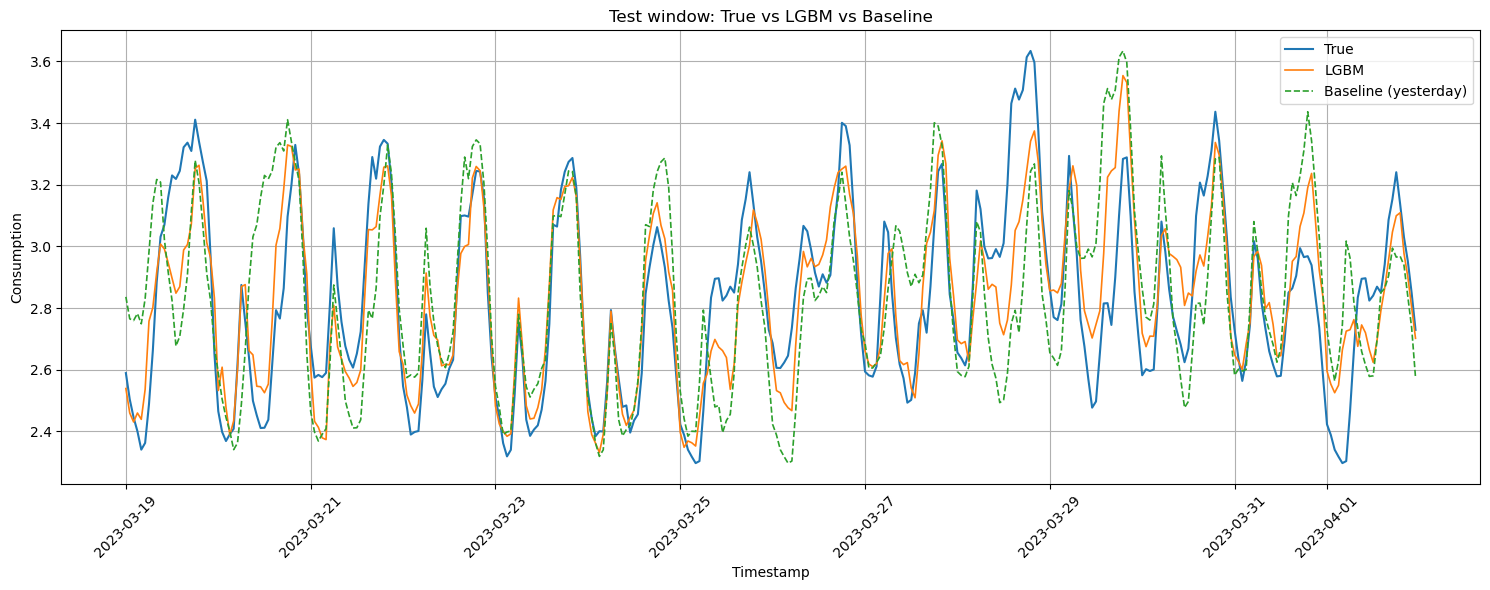

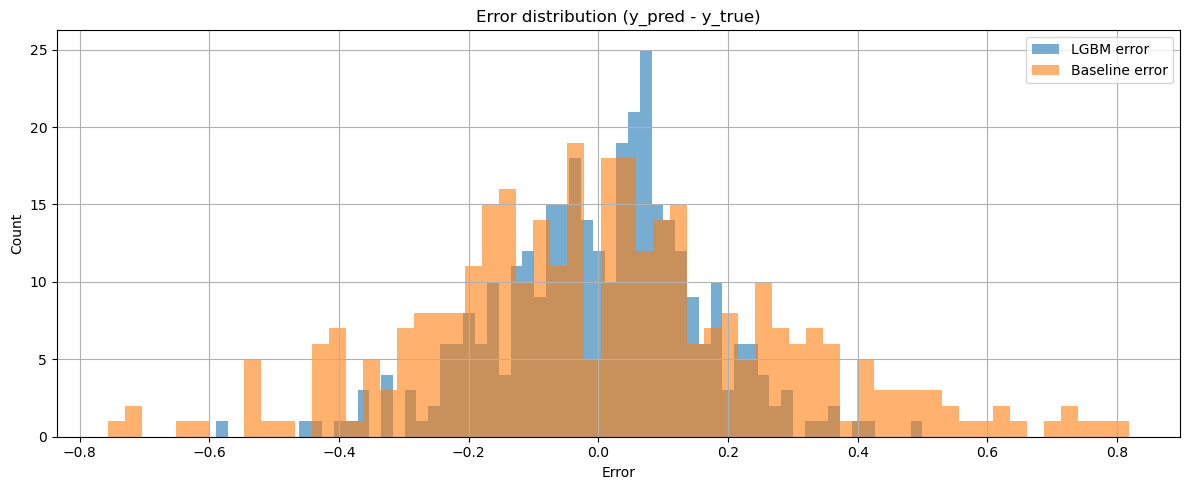

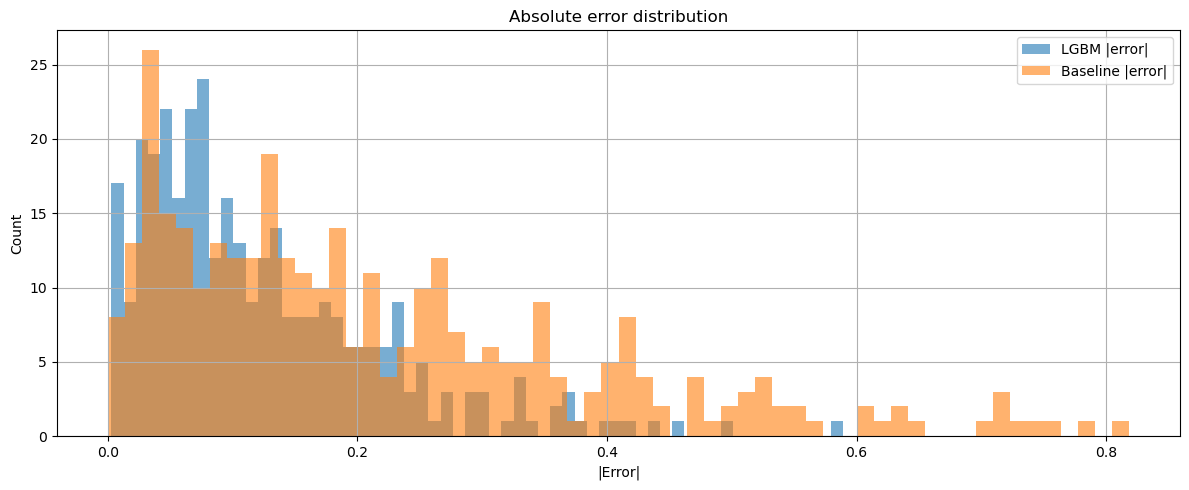

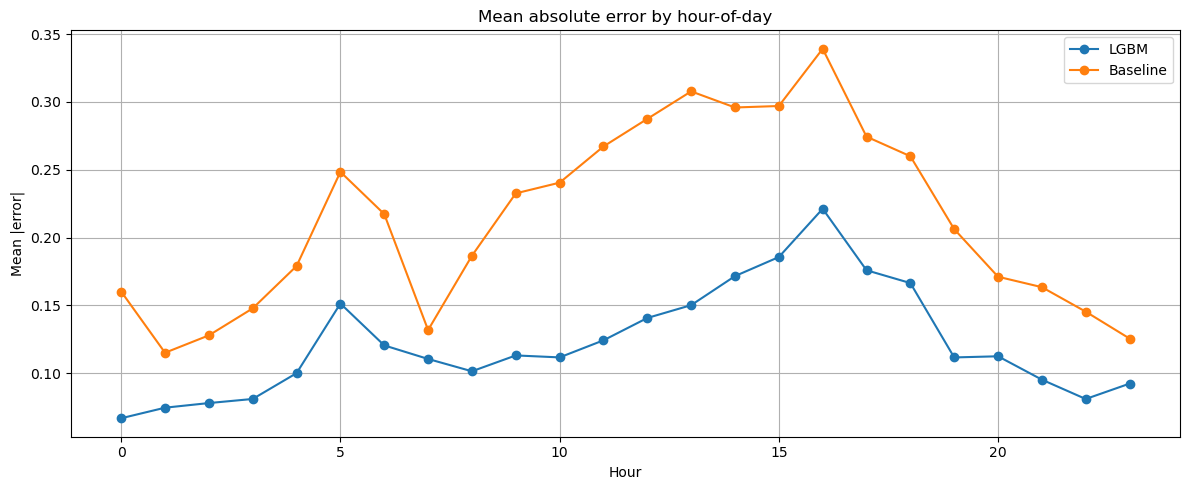

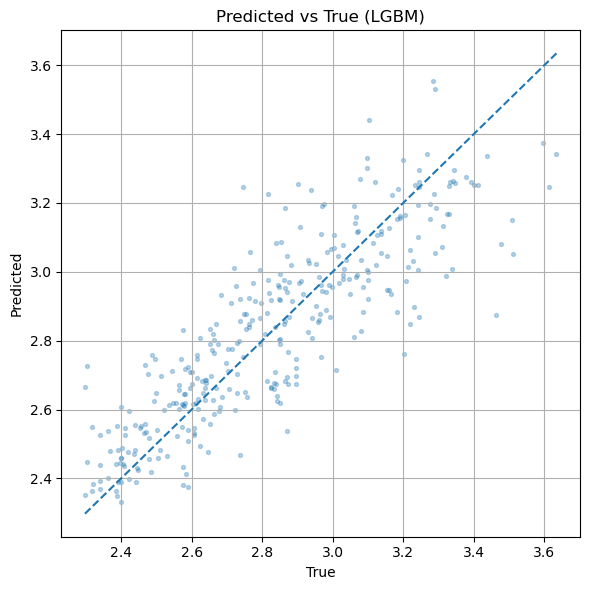

/var/folders/5j/rf69ky7d5r7c6q9vmn2z2psw0000gn/T/ipykernel_18215/2213483486.py:138: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_mae = viz.groupby("date").apply(lambda g: np.mean(np.abs(g["y_pred"] - g["y_true"]))).sort_values(ascending=False)


Top 3 worst days (by MAE): [datetime.date(2023, 3, 28), datetime.date(2023, 3, 29), datetime.date(2023, 3, 19)]


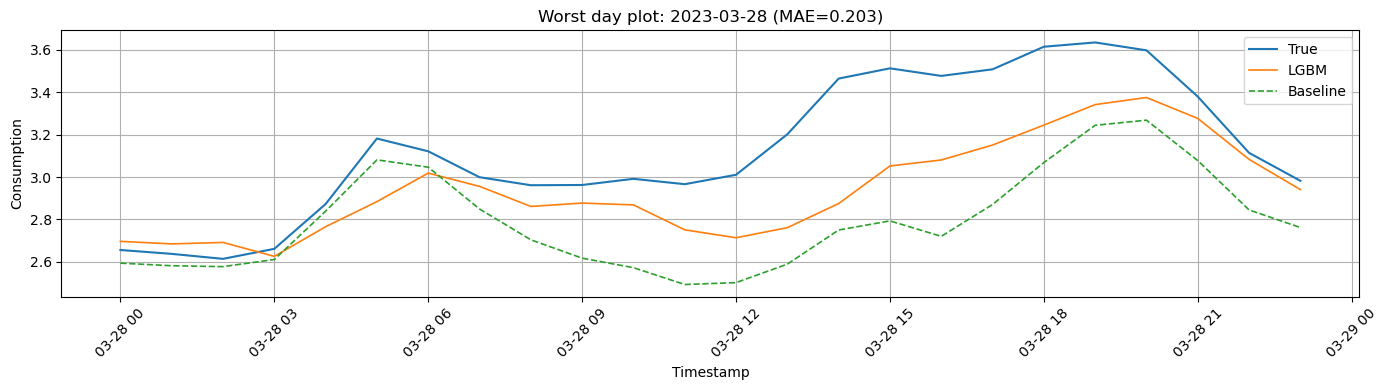

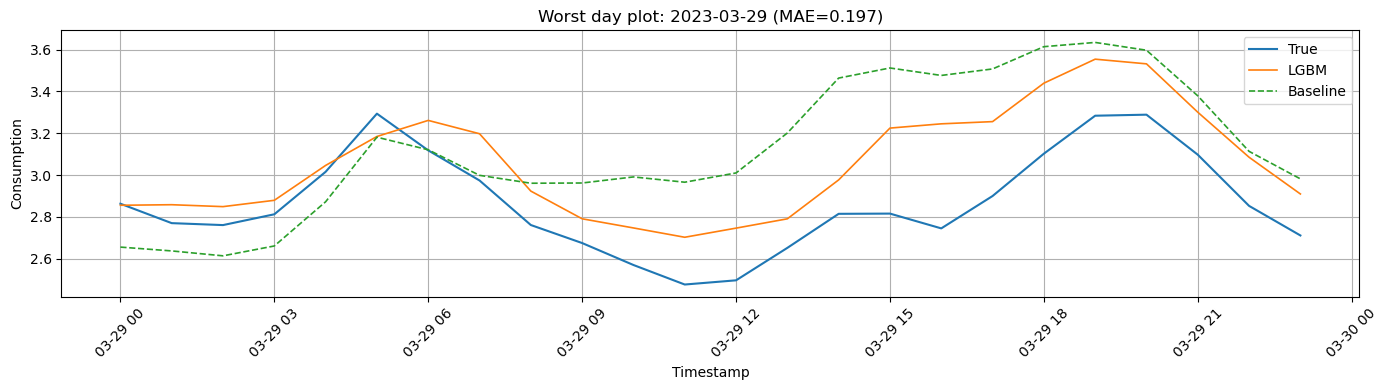

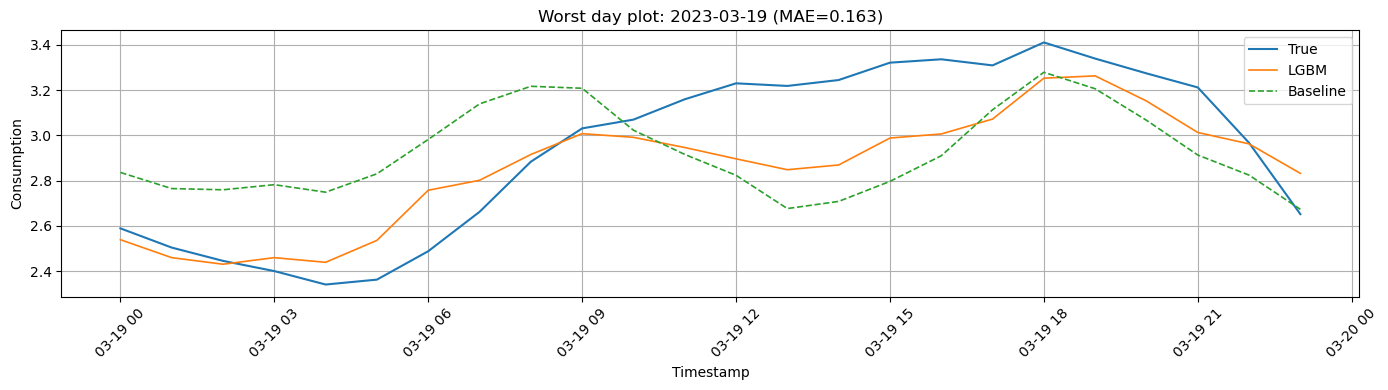

Aggregate MAE: LGBM=0.1224 | Baseline=0.2137 | Improvement=42.72%


In [57]:
# ==========================================
# Test visualizations (better + more views)
# Uses: daily_metrics, predictions, baseline_predictions
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Ensure timestamps are datetime ---
predictions = predictions.copy()
baseline_predictions = baseline_predictions.copy()
predictions["timestamp"] = pd.to_datetime(predictions["timestamp"])
baseline_predictions["timestamp"] = pd.to_datetime(baseline_predictions["timestamp"])

# Align baseline to predictions timestamps (safe)
base_aligned = (
    baseline_predictions[["timestamp", "y_pred"]]
    .rename(columns={"y_pred": "y_pred_baseline"})
    .set_index("timestamp")
)
pred_aligned = predictions.set_index("timestamp")
viz = pred_aligned.join(base_aligned, how="left").reset_index()

# -------------------------
# 1) Daily metrics over time
# -------------------------
plt.figure(figsize=(12, 5))
plt.plot(daily_metrics["forecast_date"], daily_metrics["MAE"], marker="o")
plt.title("Daily MAE over test window")
plt.xlabel("Forecast day")
plt.ylabel("MAE")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(daily_metrics["forecast_date"], daily_metrics["SMAPE_%"], marker="o")
plt.title("Daily SMAPE% over test window")
plt.xlabel("Forecast day")
plt.ylabel("SMAPE (%)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------
# 2) Overall time series: True vs Model vs Baseline
# -------------------------
plt.figure(figsize=(15, 6))
plt.plot(viz["timestamp"], viz["y_true"], label="True", linewidth=1.5)
plt.plot(viz["timestamp"], viz["y_pred"], label="LGBM", linewidth=1.2)
plt.plot(viz["timestamp"], viz["y_pred_baseline"], label="Baseline (yesterday)", linestyle="--", linewidth=1.2)
plt.title("Test window: True vs LGBM vs Baseline")
plt.xlabel("Timestamp")
plt.ylabel("Consumption")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# 3) Error distribution: histogram + CDF-ish view
# -------------------------
err_model = (viz["y_pred"] - viz["y_true"]).dropna()
err_base  = (viz["y_pred_baseline"] - viz["y_true"]).dropna()

plt.figure(figsize=(12, 5))
plt.hist(err_model, bins=60, alpha=0.6, label="LGBM error")
plt.hist(err_base, bins=60, alpha=0.6, label="Baseline error")
plt.title("Error distribution (y_pred - y_true)")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

abs_err_model = np.abs(err_model)
abs_err_base  = np.abs(err_base)

plt.figure(figsize=(12, 5))
plt.hist(abs_err_model, bins=60, alpha=0.6, label="LGBM |error|")
plt.hist(abs_err_base, bins=60, alpha=0.6, label="Baseline |error|")
plt.title("Absolute error distribution")
plt.xlabel("|Error|")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# 4) Error by hour-of-day (mean absolute error)
# -------------------------
tmp = viz.copy()
tmp["hour"] = tmp["timestamp"].dt.hour
tmp["abs_err_model"] = np.abs(tmp["y_pred"] - tmp["y_true"])
tmp["abs_err_base"]  = np.abs(tmp["y_pred_baseline"] - tmp["y_true"])

hour_mae = tmp.groupby("hour")[["abs_err_model", "abs_err_base"]].mean()

plt.figure(figsize=(12, 5))
plt.plot(hour_mae.index, hour_mae["abs_err_model"], marker="o", label="LGBM")
plt.plot(hour_mae.index, hour_mae["abs_err_base"], marker="o", label="Baseline")
plt.title("Mean absolute error by hour-of-day")
plt.xlabel("Hour")
plt.ylabel("Mean |error|")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# 5) Scatter: predicted vs true (sanity check)
# -------------------------
sample = viz.dropna(subset=["y_true", "y_pred"]).sample(min(5000, len(viz)), random_state=42)

plt.figure(figsize=(6, 6))
plt.scatter(sample["y_true"], sample["y_pred"], s=8, alpha=0.3)
m = min(sample["y_true"].min(), sample["y_pred"].min())
M = max(sample["y_true"].max(), sample["y_pred"].max())
plt.plot([m, M], [m, M], linestyle="--")
plt.title("Predicted vs True (LGBM)")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# 6) Worst days: plot top 3 by daily MAE (True vs LGBM vs Baseline)
# -------------------------
# Create per-day MAE from predictions for robust selection (uses exact timestamps)
viz["date"] = viz["timestamp"].dt.normalize()
day_mae = viz.groupby("date").apply(lambda g: np.mean(np.abs(g["y_pred"] - g["y_true"]))).sort_values(ascending=False)

top_days = day_mae.head(3).index.tolist()
print("Top 3 worst days (by MAE):", [d.date() for d in top_days])

for d in top_days:
    g = viz[viz["date"] == d].sort_values("timestamp")
    plt.figure(figsize=(14, 4))
    plt.plot(g["timestamp"], g["y_true"], label="True", linewidth=1.5)
    plt.plot(g["timestamp"], g["y_pred"], label="LGBM", linewidth=1.2)
    plt.plot(g["timestamp"], g["y_pred_baseline"], label="Baseline", linestyle="--", linewidth=1.2)
    plt.title(f"Worst day plot: {d.date()} (MAE={day_mae.loc[d]:.3f})")
    plt.xlabel("Timestamp")
    plt.ylabel("Consumption")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------
# 7) Improvement vs baseline (aggregate)
# -------------------------
model_mae = np.mean(np.abs(viz["y_pred"] - viz["y_true"]))
base_mae  = np.mean(np.abs(viz["y_pred_baseline"] - viz["y_true"]))

print(f"Aggregate MAE: LGBM={model_mae:.4f} | Baseline={base_mae:.4f} | "
      f"Improvement={(base_mae - model_mae)/base_mae*100:.2f}%")
